In [1]:
import sys
sys.path.append('..')

from src.tacogfn.utils.molecules import evaluate_properties2

import torch
import numpy as np
from tqdm import tqdm

import rdkit
rdkit.RDLogger.DisableLog('rdApp.*')

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
generated_store = torch.load('../logs/finetune/generated_molecules.pt')

In [3]:
generated_ds_exp_store = torch.load('../logs/finetune-1.5docking_score2/generated_molecules_139.pt')

In [4]:
generated_replay_online_store = torch.load('../logs/finetune-R-PRS-WithOnline/generated_molecules_98.pt')

In [5]:
generated_bs32_store = torch.load('../logs/finetune-bs-32/generated_molecules_687.pt')

In [6]:
generated_replay_store = torch.load('../logs/finetune-R-PRS/generated_molecules_160.pt')

In [8]:
no_finetune_ds = torch.load('../misc/ranking_analysis/14gs_A_docking_scores_no_finetune.pt')

In [9]:
generated_high_beta = torch.load('../logs/finetune-1.5docking_score2-high-beta/generated_molecules_206.pt')

In [11]:
generated_high_qed = torch.load('../logs/finetune-1.5docking_score2-qed/2/generated_molecules_50.pt')

In [12]:
generated_high_qed_beta = torch.load('../logs/finetune-1.5docking_score2-qed-high-beta/2/generated_molecules_46.pt')

In [18]:
top_count = 100

In [19]:
def get_top_molecules_across_count(generated_store, top_count=100, limit=14000):
    top_100 = []
    
    docking_scores = np.array([ds for ds in generated_store['docking_scores']])[:limit]
    smiles = np.array(generated_store['generated_molecules'])[:limit]

    for i in range(top_count, len(docking_scores), 100):
        subset = docking_scores[:i]
        sorted_idx = np.argsort(subset)
        top_100.append(np.mean(subset[sorted_idx][:top_count]))

    top_100_smiles = smiles[sorted_idx[:top_count]]
    metrics = evaluate_properties2(top_100_smiles)
    metrics['docking_scores'] = np.mean(top_100[-1])
    
    return top_100, metrics

In [20]:
top_100, top_100_metrics = get_top_molecules_across_count(generated_store)
top_100_metrics

{'qeds': 0.4134949819757993,
 'sas': 0.7231319337771066,
 'diversity': 0.6240764352588154,
 'docking_scores': -9.67554}

In [21]:
import random
top_100_no_finetune = []

random.shuffle(no_finetune_ds)
for i in range(top_count, len(no_finetune_ds), 100):
    subset = no_finetune_ds[:i]
    subset.sort()
    top_100_no_finetune.append(np.mean(subset[:top_count]))

In [22]:
top_100_bs32, top_100_bs32_metrics = get_top_molecules_across_count(generated_bs32_store)
top_100_bs32_metrics

{'qeds': 0.432266655798381,
 'sas': 0.7275265249412115,
 'diversity': 0.6291703745620889,
 'docking_scores': -9.62802}

In [23]:
top_100_replay, top_100_replay_metrics = get_top_molecules_across_count(generated_replay_store)
top_100_replay_metrics

{'qeds': 0.36239116800379734,
 'sas': 0.6841827033637543,
 'diversity': 0.6064331584436439,
 'docking_scores': -9.517419986724853}

In [24]:
top_100_replay_online, top_100_replay_online_metrics = get_top_molecules_across_count(generated_replay_online_store)
top_100_replay_online_metrics

{'qeds': 0.39027924745747294,
 'sas': 0.6870213091935904,
 'diversity': 0.6152051120077555,
 'docking_scores': -9.609679927825928}

In [25]:
top_100_ds_exp, top_100_ds_exp_metrics = get_top_molecules_across_count(generated_ds_exp_store)
top_100_ds_exp_metrics

{'qeds': 0.4175805092020329,
 'sas': 0.7243319277352234,
 'diversity': 0.6197321870489058,
 'docking_scores': -9.749460029602051}

In [26]:
top_100_ds_exp_beta, top_100_ds_exp_beta_metrics = get_top_molecules_across_count(generated_high_beta)
top_100_ds_exp_beta_metrics 

{'qeds': 0.5192061985027192,
 'sas': 0.8042515600561557,
 'diversity': 0.5901336286630554,
 'docking_scores': -9.734699974060058}

In [27]:
top_100_high_qed, top_100_high_qed_metrics = get_top_molecules_across_count(generated_high_qed)
top_100_high_qed_metrics

{'qeds': 0.4741347677141843,
 'sas': 0.6891628979287109,
 'diversity': 0.6179004514418737,
 'docking_scores': -9.605399990081787}

In [28]:
top_100_high_qed_beta, top_100_high_qed_beta_metrics = get_top_molecules_across_count(generated_high_qed_beta)
top_100_high_qed_beta_metrics

{'qeds': 0.6146291484111427,
 'sas': 0.7278952235258629,
 'diversity': 0.6318425282603829,
 'docking_scores': -9.56507999420166}

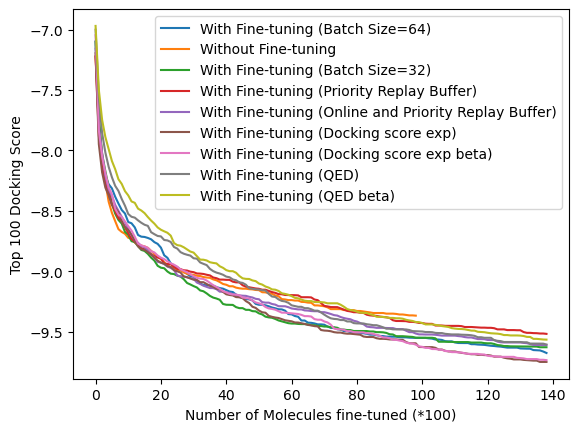

In [29]:
import matplotlib.pyplot as plt

plt.plot(top_100, label='With Fine-tuning (Batch Size=64)')
plt.plot(top_100_no_finetune, label='Without Fine-tuning')
plt.plot(top_100_bs32, label='With Fine-tuning (Batch Size=32)')
plt.plot(top_100_replay, label='With Fine-tuning (Priority Replay Buffer)')
plt.plot(top_100_replay_online, label='With Fine-tuning (Online and Priority Replay Buffer)')
plt.plot(top_100_ds_exp, label='With Fine-tuning (Docking score exp)')
plt.plot(top_100_ds_exp_beta, label='With Fine-tuning (Docking score exp beta)')
plt.plot(top_100_high_qed, label='With Fine-tuning (QED)')
plt.plot(top_100_high_qed_beta, label='With Fine-tuning (QED beta)')
plt.ylabel('Top 100 Docking Score')
plt.xlabel('Number of Molecules fine-tuned (*100)')
plt.legend()
plt.show()


In [37]:
import json

In [40]:
file_path = '../misc/generated_molecules/20240512_1.0_1.0_1000_finetune-1.5docking_score2-pocket2-generation.json'

with open(file_path, 'r') as f:
    data = json.load(f)

In [60]:
all_scores = generated_ds_exp_store['docking_scores'][:13800]

In [61]:
new_scores = all_scores[:12800] + data['14gs_A']['docking_scores']

In [62]:
print(np.mean(sorted(all_scores)[:100]))

-9.749460029602051


In [63]:
print(np.mean(sorted(new_scores)[:100]))

-9.752590017318726
